# Binary cross entropy vs cross entropy loss functions in PyTorch?

Sometimes when designing a classifier we don't quite know how many output classes there will be. We can design a multi class model and then realise a binary classification model would suffice. When creating a multi class model in PyTorch we typically use the `CrossEntropyLoss` loss function. For a binary classification model we would usually use `BCEWithLogitsLoss`. However, for a binary classification problem, if we use `CrossEntropyLoss` loss we end up with twice as many weights than using `BCEWithLogitsLoss`. Does this matter...?

To do a quite check we can create some dummy binary classification data and fit a few models. We'll fit the same model structure with different loss functions and see what the differences are.

## Create data

We create random data from a binary classification problem. Then we convert to PyTorch dataloaders for training our models.

> Note: We use no parallel workers for the dataloader as it slows down loading data a lot when the dataset can fit in memory.

In [1]:
import torch
import numpy as np
import scipy.special

n = 100_000  # number of data points
m = 4  # number of features

torch.manual_seed(0)
random = np.random.default_rng(seed=0)
w = random.normal(size=(m, 1))  # weights vector
b = random.normal(size=1)
X = random.normal(size=(n, m))
y_logit = b + np.dot(X, w) + random.normal(scale=0.0, size=(n, 1))
y = random.binomial(n=1, p=scipy.special.expit(y_logit)).flatten()

# split to train/test
X_train, X_test, y_train, y_test = (
    X[: int(n / 2)],
    X[int(n / 2) :],
    y[: int(n / 2)],
    y[int(n / 2) :],
)

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(X_train), torch.Tensor(y_train)
)
test_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(X_test), torch.Tensor(y_test)
)

# create to data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=int(n / 2), shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=int(n / 2), shuffle=False
)

## Build models

Here we'll define some common functions. Namely, to train a pytorch lightning models and evaluate model performance.

Metrics - we use log likelihood and accuracy (we have a class split of 50/50 so this is reasonable)


In [2]:
import sklearn.metrics
import pandas as pd
import pytorch_lightning as pl

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")


def tensor_to_sklearn_pred(pred):
    return np.stack([1 - pred, pred]).transpose()


def evaluate_predictions_with_skl(y_train, y_train_est, y_test, y_test_est) -> dict:
    return {
        "log_loss_train": sklearn.metrics.log_loss(y_train, y_train_est),
        "log_loss_test": sklearn.metrics.log_loss(y_test, y_test_est),
        "accuracy_score_train": sklearn.metrics.accuracy_score(
            y_train, y_train_est[:, 1] > y_train_est[:, 0]
        ),
        "accuracy_score_test": sklearn.metrics.accuracy_score(
            y_test, y_test_est[:, 1] > y_test_est[:, 0]
        ),
    }


def evaluate_all_models(model_outputs: dict) -> pd.DataFrame:
    results = []
    for name, model_output in model_outputs.items():
        _results = evaluate_predictions_with_skl(
            y_train, model_output[0], y_test, model_output[1]
        )
        _results["name"] = name
        results.append(_results)
    return pd.DataFrame(results)


def train_torch_model(
    model,
    epochs: int = 100,
    train_loader=train_loader,
    test_loader=test_loader,
    accelerator="gpu",
):
    trainer = pl.Trainer(
        max_epochs=epochs, enable_progress_bar=True, accelerator=accelerator
    )
    trainer.fit(model, train_loader, test_loader)


def plot_training_logs(model):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(model.log_train), label="train_LL")
    ax.plot(np.array(model.log_val), label="test_LL")
    ax.set(xlabel="Step", ylabel="Logloss")
    ax.legend()
    fig.show()


def predict_data_loader(model, data_loader):
    model.eval()

    y_est = []
    y_true = []
    with torch.no_grad():
        for img_batch, label_batch in data_loader:
            output = model(img_batch)
            probs = torch.nn.functional.sigmoid(output)

            y_est.append(probs)
            y_true.append(label_batch)

    y_est = torch.cat(y_est)
    y_true = torch.cat(y_true)

    return y_est, y_true


model_outputs = {}
model_times = {}
model_parameters = {}

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_69550/494113661.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


### Binary cross entropy

The model we build is a binary classifier with a single linear layer, a logistic regression. We set the criterion to `BCEWithLogitsLoss`.
Given we have 4 features, there are only 5 parameters to learn here.

We train the model for 50 epochs and time how long it takes.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | classifier | Linear            | 5     
1 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s, v_num=195, train_loss=0.616, val_loss_step=0.618, val_loss_epoch=0.618]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s, v_num=195, train_loss=0.616, val_loss_step=0.618, val_loss_epoch=0.618]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_69550/494113661.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


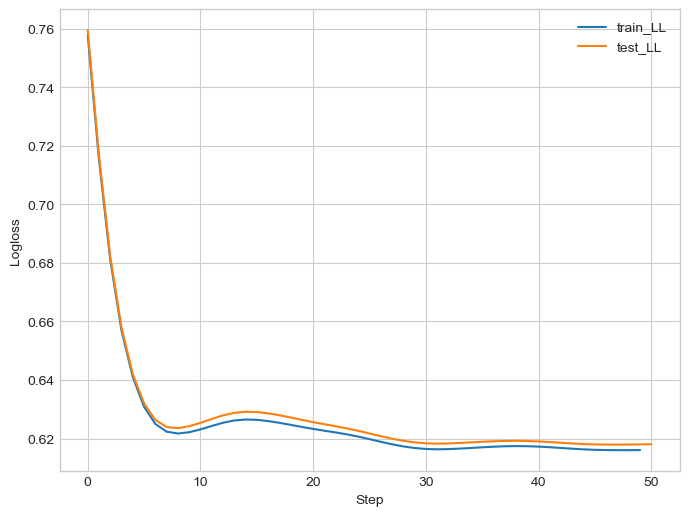

In [3]:
import torch.nn as nn
import timeit


class BCEModel(pl.LightningModule):
    def __init__(self, input_features: int, learning_rate=0.01):
        super().__init__()

        self.classifier = nn.Linear(input_features, 1)

        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # training logs
        self.log_train = []
        self.log_val = []

    def forward(self, x):
        x = self.classifier(x)
        return x.flatten()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())

    def configure_optimizers(self):
        return self.optimizer


model_lightning = BCEModel(learning_rate=1e-1, input_features=m)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=50)
model_times["logistic_reg_bce"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["logistic_reg_bce"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]
model_parameters["logistic_reg_bce"] = model_lightning.parameters()

## Cross Entropy

Now we do the same but using `CrossEntropyLoss`. This requires an output per possible target class. We have a single class, where the target takes on 0 or 1. However for a multi class problem that is considered as two classes, 0 and 1. So we can adjust the single output, `p(x)`, to make the output in the form:

```
[p(x), 1-p(x)]
```

As the output is in logits we need to use the `expit` and `logit` function to do the transform. This is now the same model as before with 5 parameters, but using `CrossEntropyLoss`.

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type             | Params
------------------------------------------------
0 | classifier | Linear           | 5     
1 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              torch.Size([50000, 4])
torch.Size([50000, 2])
torch.Size([50000])
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=196, train_loss=0.748, val_loss_step=0.689, val_loss_epoch=0.689]        torch.Size([50000, 4])
torch.Size([50000, 2])
torch.Size([50000])
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=196, train_loss=0.686, val_loss_step=0.650, val_loss_epoch=0.650]        torch.Size([50000, 4])
torch.Size([50000, 2])
torch.Size([50000])
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=196, train_loss=0.647, val_loss_step=0.633, val_loss_epoch=0.633]        torch.Size([50000, 4])
torch.Size([50000, 2])
torch.Size([50000])
Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=196, train_loss=0.631, val_loss_step=0.630, val_loss_epoch=0.630]        torch.Size([50000, 4])
torch.Size([50000, 2])
torch.Size([50000])
Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=196, train_loss=0.627, val_loss_step=

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s, v_num=196, train_loss=0.616, val_loss_step=0.618, val_loss_epoch=0.618]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_69550/494113661.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


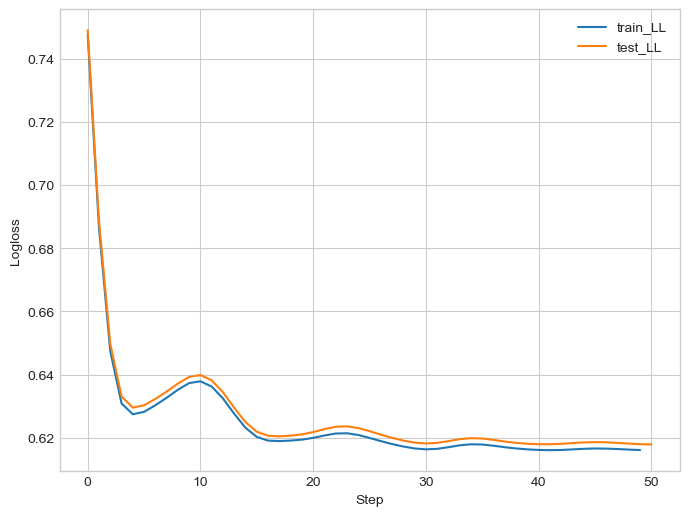

In [4]:
class CrossEntropyModel(pl.LightningModule):
    def __init__(self, input_features: int, learning_rate=0.01):
        super().__init__()

        self.classifier = nn.Linear(input_features, 1)

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # training logs
        self.log_train = []
        self.log_val = []

    def forward(self, x):
        x = self.classifier(x)
        x = torch.concat([torch.special.logit(1 - torch.special.expit(x)), x], dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        print(x.shape)
        print(y_hat.shape)
        print(y.shape)
        loss = self.criterion(y_hat, y.type(torch.long))
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.type(torch.long))
        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())

    def configure_optimizers(self):
        return self.optimizer


model_lightning = CrossEntropyModel(learning_rate=1e-1, input_features=m)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=50, accelerator="cpu")
model_times["logistic_reg_ce"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["logistic_reg_ce"] = [y_train_est.numpy(), y_test_est.numpy()]
model_parameters["logistic_reg_ce"] = model_lightning.parameters()

## Cross Entropy 2 classes

The final model uses `CrossEntropyLoss` in the normal way. We create an output layer with 2 nodes. Therefore this model has twice as many parameters as before.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | classifier | Linear           | 10    
1 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, v_num=197, train_loss=0.616, val_loss_step=0.618, val_loss_epoch=0.618]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, v_num=197, train_loss=0.616, val_loss_step=0.618, val_loss_epoch=0.618]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_69550/494113661.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


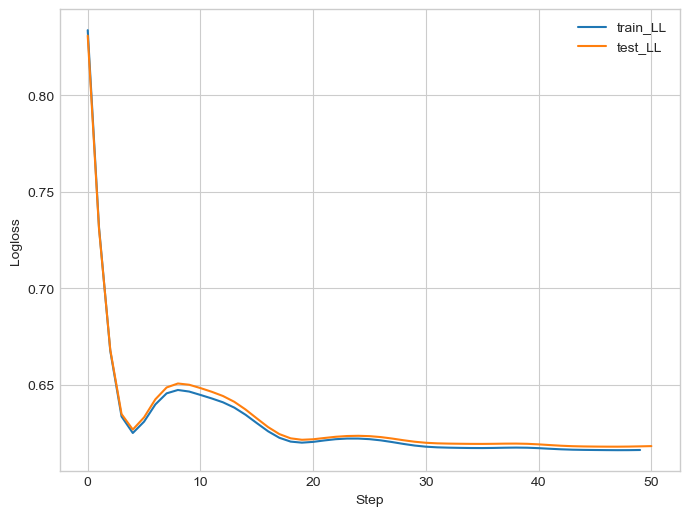

In [5]:
class CrossEntropy2ClassModel(pl.LightningModule):
    def __init__(self, input_features: int, learning_rate=0.01):
        super().__init__()

        self.classifier = nn.Linear(input_features, 2)

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # training logs
        self.log_train = []
        self.log_val = []

    def forward(self, x):
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.type(torch.long))
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.type(torch.long))
        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())

    def configure_optimizers(self):
        return self.optimizer


model_lightning = CrossEntropy2ClassModel(learning_rate=1e-1, input_features=m)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=50)
model_times["logistic_reg_ce2"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["logistic_reg_ce2"] = [y_train_est.numpy(), y_test_est.numpy()]
model_parameters["logistic_reg_ce2"] = model_lightning.parameters()

## Results

Lets check the model performance in a few ways:

### Performance

We don't see any significant difference in performance between models. Log likelihood and accuracy are similar, within reason, across all models.
These are small models to fit, so perhaps a much large model would present differently, and a model with twice as many parameters would overfit more readily...

In [6]:
evaluate_all_models(model_outputs)

,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.616102,0.618044,0.65992,0.65580,logistic_reg_bce
1,0.634614,0.635658,0.66044,0.65568,logistic_reg_ce
2,0.643445,0.644258,0.65938,0.65642,logistic_reg_ce2


### Training time

We don't see any significant difference in training time between models.

In [7]:
model_times

{'logistic_reg_bce': 28.00450733397156,
 'logistic_reg_ce': 24.72408683411777,
 'logistic_reg_ce2': 25.281254459172487}

### Parameters

The weights of the binary class models are similar to the true weights from the data generating function. However the 2 output model has twice as many parameters and thus the interpretation of the weights is not clear here:

In [8]:
print("True weights:")
display(w)
print("True bias:")
display(b)

for name, params in model_parameters.items():
    print(f"{name}: ")
    display(list(params))

True weights:


array([[ 0.12573022],
       [-0.13210486],
       [ 0.64042265],
       [ 0.10490012]])

True bias:


array([-0.53566937])

logistic_reg_bce: 


[Parameter containing:
 tensor([[ 0.1037, -0.1576,  0.6802,  0.1207]], requires_grad=True),
 Parameter containing:
 tensor([-0.5245], requires_grad=True)]

logistic_reg_ce: 


[Parameter containing:
 tensor([[ 0.0615, -0.0684,  0.3213,  0.0474]], requires_grad=True),
 Parameter containing:
 tensor([-0.2585], requires_grad=True)]

logistic_reg_ce2: 


[Parameter containing:
 tensor([[-0.0351, -0.0528, -0.5174, -0.1480],
         [ 0.0698, -0.2241,  0.0729, -0.0377]], requires_grad=True),
 Parameter containing:
 tensor([ 0.4980, -0.0408], requires_grad=True)]

### Conclusion

There is not noticeable impact on training times or performance.
However, the parameter interpretation is much clearer from a model with a single output as we only have the one set of parameters. This probably depends on the use case - but if we want an interpretable model that matches the data generating process, we should use a model with a binary output based on `BCEWithLogitsLoss`. Otherwise it doesn't seem to matter for this type of problem.